In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Programming Exercise 8: Anomaly Detection and Recommender Systems
> In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies.

## 1. Anomaly Detection
> In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server.

In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
mat = scipy.io.loadmat('/content/drive/MyDrive/Anomaly Detection and Recommender Systems/Data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

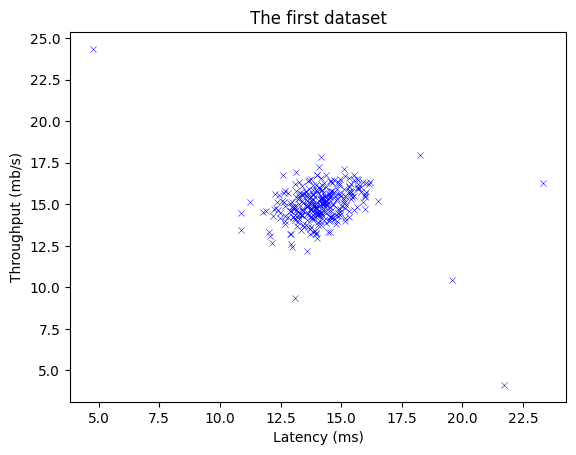

In [ ]:
ax = sns.scatterplot(x = mat['X'][:,0], y = mat['X'][:,1], marker='x', color='b', s=20)
ax.set(xlabel='Latency (ms)', ylabel='Throughput (mb/s)', title='The first dataset');

### 1.1 Gaussian Distribution

> To perform anomaly detection, you will first need to fit a model to the data’s distribution.

The Gaussian distribution is given by:

$$p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} = \frac{1}{\sqrt{(2\pi^k)det\Sigma}}e^{-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)}$$

where $\mu$ is the mean and $\sigma^2$ controls the variance; $\Sigma$ is the covariance matrix and $k$ is the dimension of the space where $x$ takes values.

### 1.2 Estimating Parameters for a Gaussian

Mean: $\mu_i = \frac{1}{m}\sum_{j=1}^m x_i^{(j)}$

Variance: $\sigma_i^2 = \frac{1}{m}\sum_{j=1}^m(x_i^{(j)}-\mu_i)^2$

In [ ]:
def estimate_gaussian(X):
    mean = np.mean(X, axis=0)
    var = np.var(X, axis=0)
    return mean, var

In [ ]:
from scipy.stats import multivariate_normal
def multivariate_gaussian(X, mu, sigma):
    p = multivariate_normal.pdf(X, mu, np.diag(sigma))
    return p

In [ ]:
mu, sigma2 = estimate_gaussian(mat['X'])
mu, sigma2

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [ ]:
p = multivariate_gaussian(mat['X'], mu, sigma2)

In [ ]:
def visualize_fit(X, mu, sigma2):
    x, y = np.mgrid[0:35.5:0.5, 0:35.5:0.5]
    pos = np.dstack((x, y))
    z = multivariate_gaussian(pos, mu, sigma2)
    z = z.reshape(x.shape)
    ax = sns.scatterplot(x = X[:,0], y = X[:,1], marker='x', color='b', s=20)
    ax.contour(x, y, z, levels=10.0**(np.arange(-20,0,3)))
    ax.set(xlabel='Latency (ms)', ylabel='Throughput (mb/s)', title='Visualizing Gaussian Fit');
    ax.set_xlim(0,30)
    ax.set_ylim(0,30)
    return ax

<Axes: title={'center': 'Visualizing Gaussian Fit'}, xlabel='Latency (ms)', ylabel='Throughput (mb/s)'>

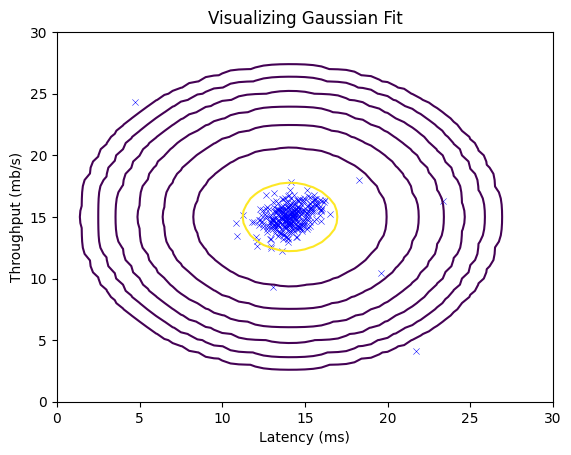

In [ ]:
visualize_fit(mat['X'], mu, sigma2)

### 1.3 Selecting the threshold $\epsilon$

The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\epsilon$ using the $F1 score$ on a cross validation set.

$$F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}$$

$$prec = \frac{tp}{tp+fp}$$

$$rec = \frac{tp}{tp+fn}$$

* tp: true positive; label says it's true and our algorithm too
* fp: false positive; label says it's not true and our algorithm says it's true
* fn: false negative; label says it's true and our algorithm says it's not true

In [ ]:
def select_threshold(yval, pval):
    best_f1 = 0
    best_epsilon = 0
    step = (np.max(pval) - np.min(pval))/1000
    for epsilon in np.arange(np.min(pval), np.max(pval), step):
        y_pred = pval < epsilon
        tp = np.sum(np.logical_and(yval == 1, y_pred == 1))
        fp = np.sum(np.logical_and(yval == 0, y_pred == 1))
        fn = np.sum(np.logical_and(yval == 1, y_pred == 0))

        precision = tp / (tp+fp)
        recall = tp / (tp+fn)

        f1 = (2*precision*recall)/(precision+recall)
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    return best_epsilon, best_f1

In [ ]:
pval = multivariate_gaussian(mat['Xval'], mu, sigma2)

In [ ]:
epsilon, f1 = select_threshold(mat['yval'].ravel(), pval)

<ipython-input-14-25faf90e2ce0>:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp+fp)


In [ ]:
print('Best epsilon found using cross-validation:', epsilon)
print('Best F1 on Cross Validation Set:', f1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

Best epsilon found using cross-validation: 8.990852779269493e-05
Best F1 on Cross Validation Set: 0.8750000000000001
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


In [ ]:
outliers = np.argwhere(p < epsilon)
outliers = outliers.T[0]

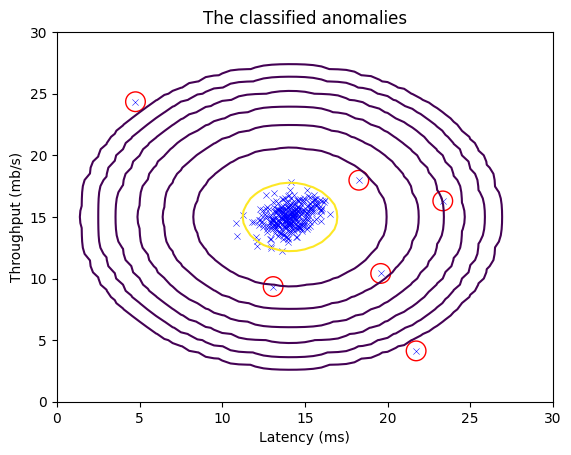

In [ ]:
ax = visualize_fit(mat['X'], mu, sigma2)
ax.scatter(x=mat['X'][outliers,0], y=mat['X'][outliers,1], color='r', facecolors='none', s=200)
ax.set(title='The classified anomalies');

### 1.4 High Dimensional Dataset

In [ ]:
mat = scipy.io.loadmat('/content/drive/MyDrive/Anomaly Detection and Recommender Systems/Data/ex8data2.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [ ]:
mu, sigma2 = estimate_gaussian(mat['X'])
p = multivariate_gaussian(mat['X'], mu, sigma2)
pval = multivariate_gaussian(mat['Xval'], mu, sigma2)
epsilon, f1 = select_threshold(mat['yval'].ravel(), pval)

<ipython-input-14-25faf90e2ce0>:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp+fp)


In [ ]:
print('Best epsilon found using cross-validation:', epsilon)
print('Best F1 on Cross Validation Set:', f1)
print('   (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of 0.615385)')
print('# Outliers found: ', sum(p < epsilon))

Best epsilon found using cross-validation: 1.3772288907613604e-18
Best F1 on Cross Validation Set: 0.6153846153846154
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)
# Outliers found:  117
